In [1]:
import gym
import random
from itertools import count
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
torch.manual_seed(42)

device = torch.device('cpu')

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, terminated):
        self.buffer.append((state, action, reward, next_state, terminated))

    def sample(self, batch_size):
        state, action, reward, next_state, terminated = zip(*random.sample(self.buffer, batch_size))
        return torch.tensor(state), torch.tensor(action), torch.tensor(reward), torch.tensor(next_state), torch.tensor(terminated)

    def __len__(self):
        return len(self.buffer)
    

class DQN:
    def __init__(self, env, device, replay_buffer, batch_size=128, gamma=0.99, lr=1e-3):
        self.env = env
        self.device = device
        self.replay_buffer = replay_buffer
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        
        self.model = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        ).to(device)
        
        self.optimizer = Adam(self.model.parameters(), lr=self.lr)
        
    def act(self, state, epsilon):
        if random.random() < epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                state = torch.tensor(state).float().to(self.device)
                q_values = self.model(state)
                return q_values.argmax().item()
            
    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        state, action, reward, next_state, terminated = self.replay_buffer.sample(self.batch_size)
        state = state.to(self.device)
        action = action.to(self.device)
        reward = reward.to(self.device)
        next_state = next_state.to(self.device)
        terminated = terminated.to(self.device)
        
        q_values = self.model(state).gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_values = self.model(next_state).max(1)[0]
        expected_q_values = reward + self.gamma * next_q_values * (1 - terminated.float())  # Fix the subtraction error
        
        loss = (q_values - expected_q_values.detach()).pow(2).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def play(self, episodes, epsilon):
        rewards = []
        for episode in range(episodes):
            state = self.env.reset()
            episode_reward = 0
            while True:
                action = self.act(state, epsilon)
                next_state, reward, terminated, _ = self.env.step(action)
                episode_reward += reward
                self.replay_buffer.push(state, action, reward, next_state, terminated)
                state = next_state
                self.train()
                if terminated:
                    break
            rewards.append(episode_reward)
        return rewards


class DuelingDQN(DQN):
    def __init__(self, env, device, replay_buffer, batch_size=128, gamma=0.99, lr=1e-3):
        super().__init__(env, device, replay_buffer, batch_size, gamma, lr)
        
        self.model = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        ).to(device)
        
        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        ).to(device)
        
        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        ).to(device)
        
        self.optimizer = Adam(list(self.model.parameters()) + list(self.advantage.parameters()) + list(self.value.parameters()), lr=self.lr)
        
    def act(self, state, epsilon):
        if random.random() < epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                state = torch.tensor(state).float().to(self.device)
                advantage, value = self.advantage(self.model(state)), self.value(self.model(state))
                q_values = value + advantage - advantage.mean()
                return q_values.argmax().item()
            
    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        state, action, reward, next_state, terminated = self.replay_buffer.sample(self.batch_size)
        state = state.to(self.device)
        action = action.to(self.device)
        reward = reward.to(self.device)
        next_state = next_state.to(self.device)
        terminated = terminated.to(self.device)
        
        advantage = self.advantage(self.model(state)).gather(1, action.unsqueeze(1)).squeeze(1)
        value = self.value(self.model(state)).squeeze(1)
        next_value = self.value(self.model(next_state)).squeeze(1)
        expected_value = reward + self.gamma * next_value * (1 - terminated.float())
        
        loss = (advantage + value - expected_value.detach()).pow(2).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

In [3]:
env = gym.make('CartPole-v1')
env.seed(42)

replay_buffer = ReplayBuffer(100)
agent = DuelingDQN(env, device, replay_buffer)

episodes = 500
epsilon = 1
epsilon_decay = 0.995
epsilon_min = 0.01

rewards = []
losses = []

for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    while True:
        step_loss = 0
        action = agent.act(state, epsilon)
        next_state, reward, terminated, _ = env.step(action)
        episode_reward += reward
        replay_buffer.push(state, action, reward, next_state, terminated)
        state = next_state
        loss = agent.train()
        if loss is not None:
            step_loss += loss
        if terminated:
            break
    rewards.append(episode_reward)
    losses.append(step_loss)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f'\rEpisode: {episode + 1}/{episodes}, Reward: {episode_reward}, Loss: {loss}', end='')


torch.save(agent.model.state_dict(), 'ddqn_CartPole.pth')

c:\Users\Jeffey\anaconda3\envs\torch39\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Jeffey\anaconda3\envs\torch39\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Jeffey\anaconda3\envs\torch39\lib\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
c:\Users\Jeffey\anaconda3\envs\torch39\lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bo

Episode: 500/500, Reward: 103.0, Loss: 0.00306586665101349355

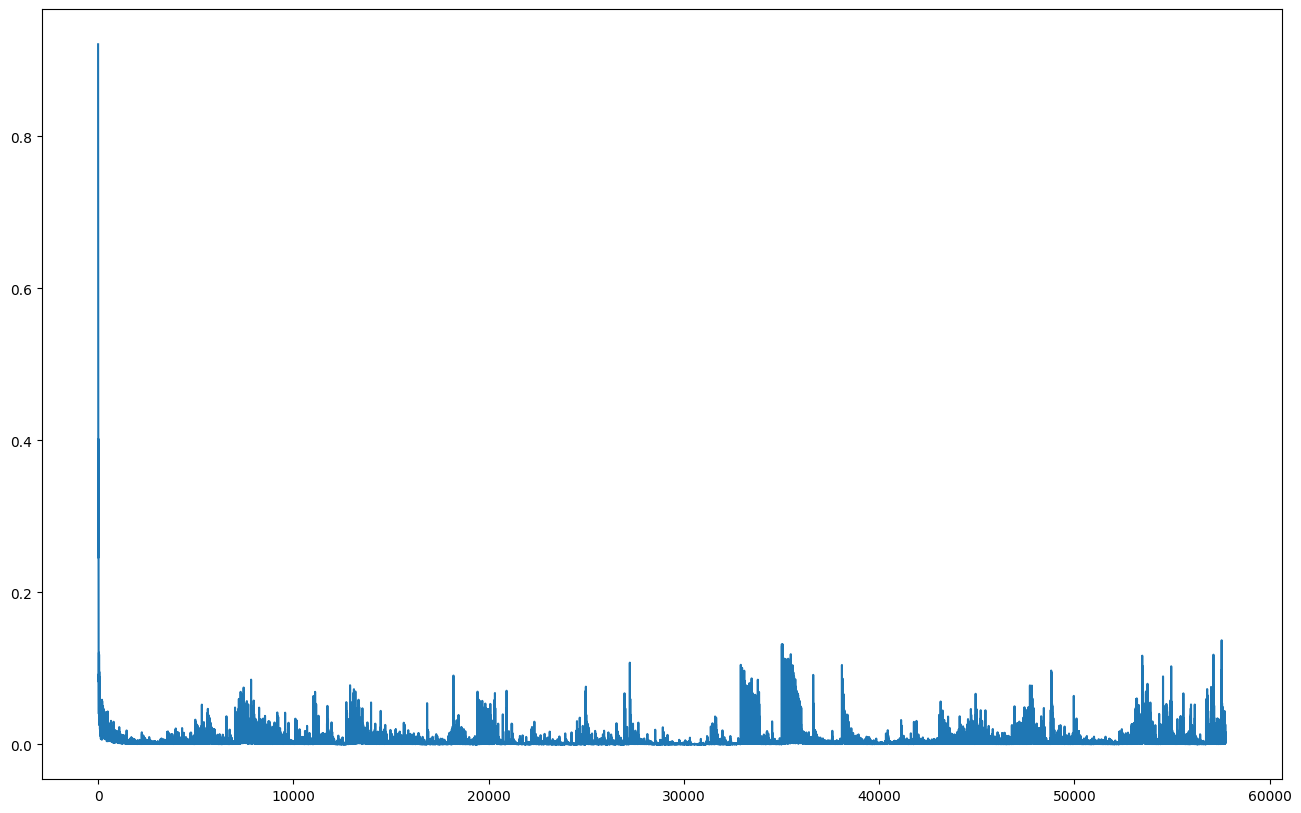

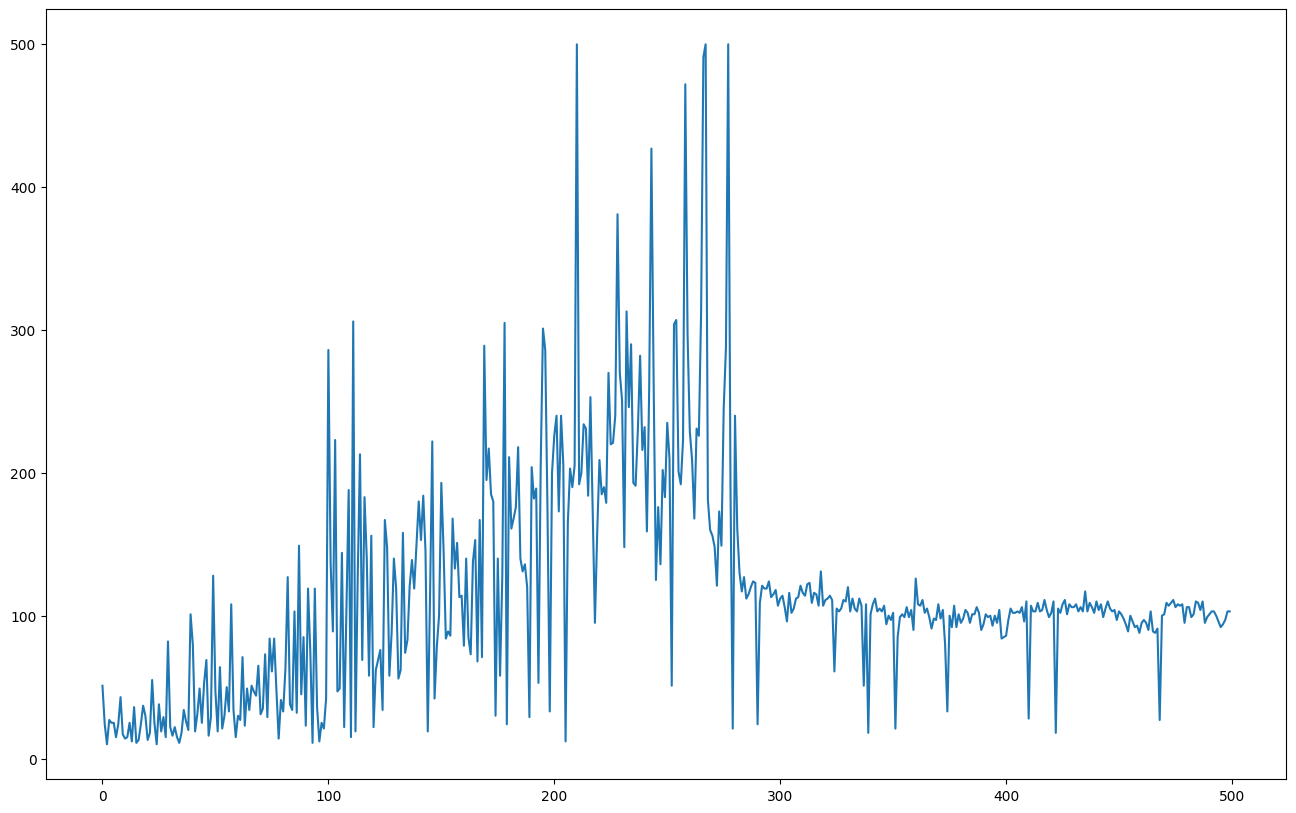

In [5]:
plt.plot(losses)
plt.show()
plt.plot(rewards)
plt.show()

In [11]:
env2 = gym.make('LunarLander-v2')
env2.seed(42)


replay_buffer = ReplayBuffer(100)
agent = DuelingDQN(env2, device, replay_buffer)

episodes = 300
epsilon = 1
epsilon_decay = 0.995
epsilon_min = 0.01

rewards2 = []
losses2 = []

for episode in range(episodes):
    state = env2.reset()
    episode_reward = 0
    episode_loss = 0
    while True:
        action = agent.act(state, epsilon)
        next_state, reward, terminated, _ = env2.step(action)
        episode_reward += reward
        replay_buffer.push(state, action, reward, next_state, terminated)
        state = next_state
        loss = agent.train()
        if loss is not None:
            episode_loss += loss
        if terminated:
            break
    rewards2.append(episode_reward)
    losses2.append(episode_loss)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f'\rEpisode: {episode + 1}/{episodes}, Reward: {episode_reward}, Loss: {loss}', end='')
    
torch.save(agent.model.state_dict(), 'ddqn_LunarLander.pth')

c:\Users\Jeffey\anaconda3\envs\torch39\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Jeffey\anaconda3\envs\torch39\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Jeffey\anaconda3\envs\torch39\lib\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
c:\Users\Jeffey\anaconda3\envs\torch39\lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bo

Episode: 500/500, Reward: -251.49894646227204, Loss: 13.736338513156968

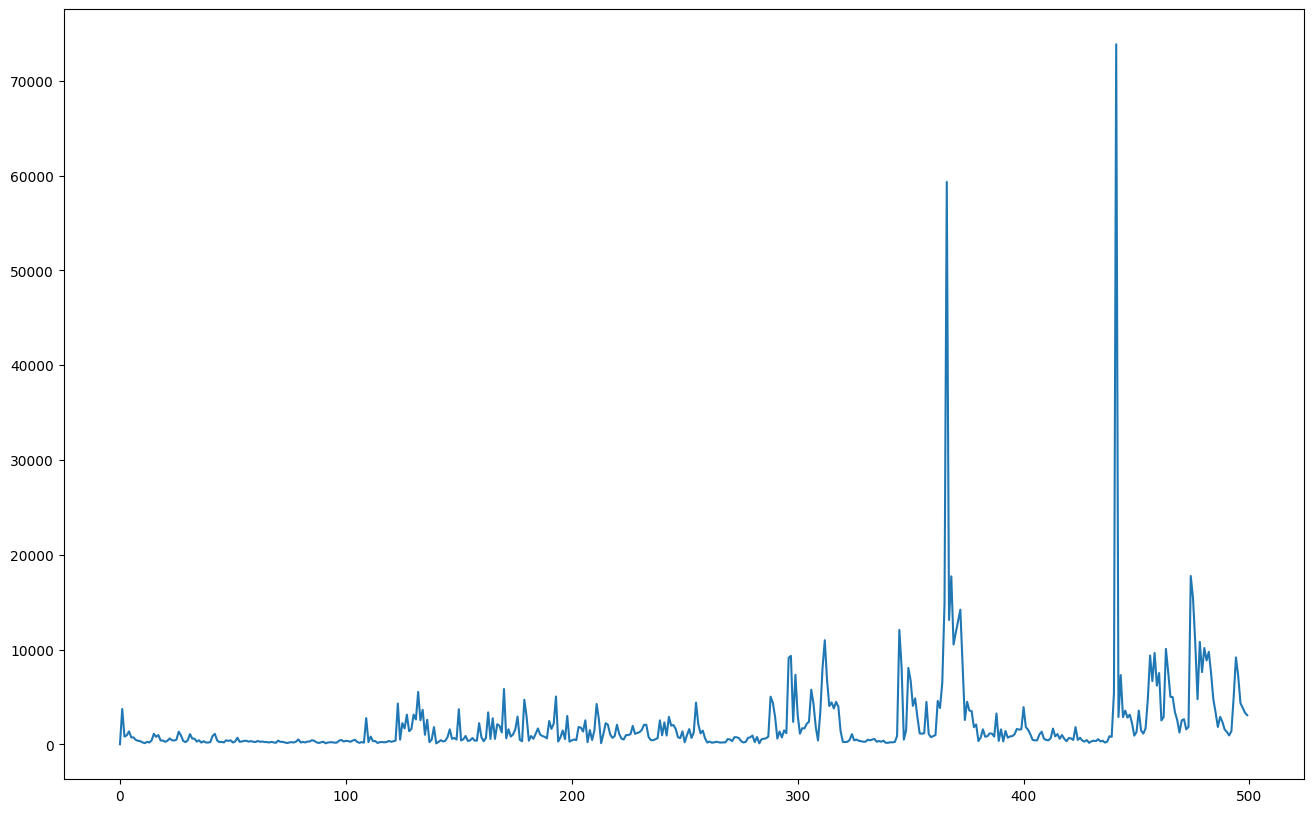

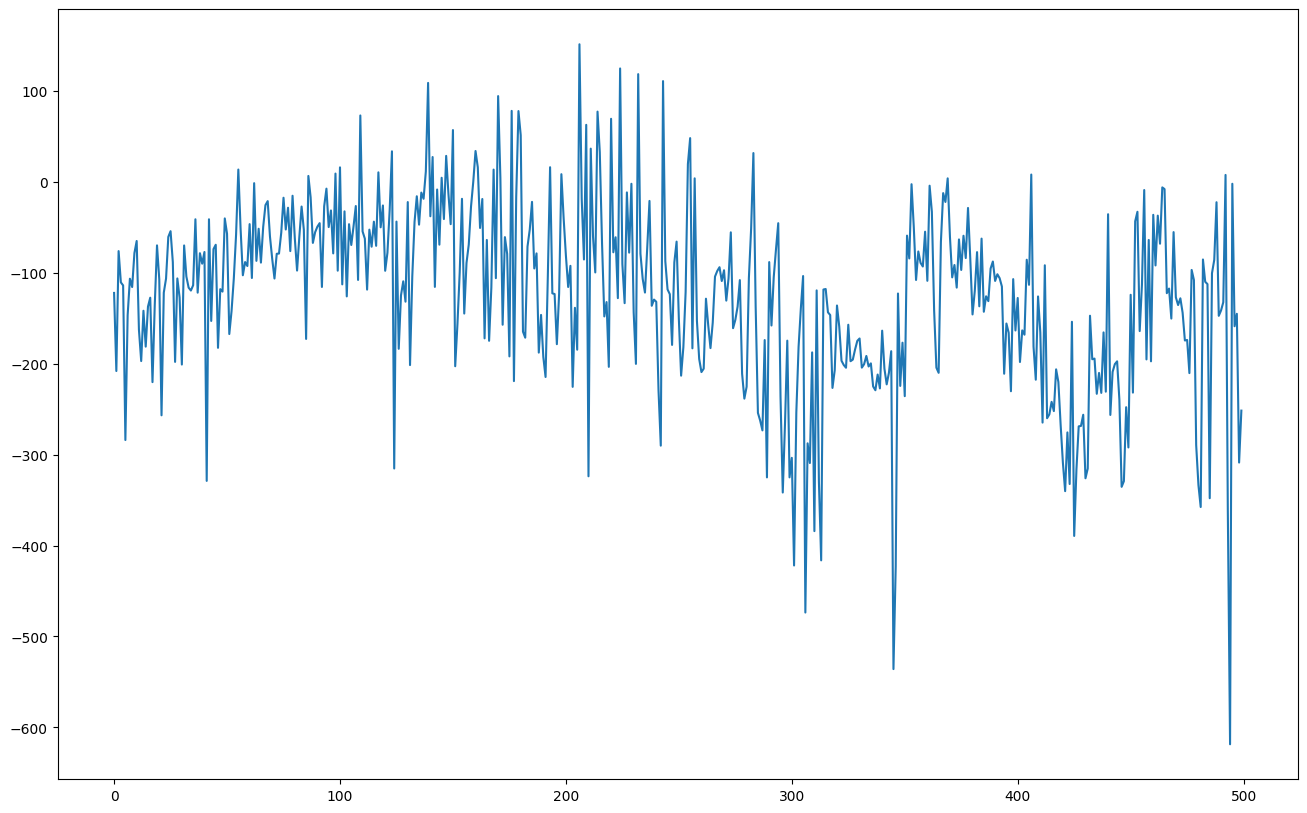

In [13]:
plt.plot(losses2)
plt.show()
plt.plot(rewards2)
plt.show()

In [27]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

env = gym.make('LunarLander-v2')

video = VideoRecorder(env, path='./video/before_training_video.mp4')
env.seed(42)
state = env.reset()


for i in range(300):
    env.render()
    video.capture_frame()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if done:
        break

video.close()
env.close()


video = VideoRecorder(env, path='./video/after_training_video.mp4')
state = env.reset()


for i in range(500):
    env.render()
    video.capture_frame()
    action = agent.act(state, 0)
    state, reward, done, info = env.step(action)

    if done:
        break
    
video.close()
env.close()